# https://github.com/KimJinSungDataScientist/deep_learning

# Load packages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd'/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [5]:
batch_size = 64
learning_rate = 0.05
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize = 256

In [6]:
img_dir = 'clothes/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2),
            transforms.RandomCrop(imgsize),
            transforms.RandomHorizontalFlip(),

            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data,batch_size=batch_size,
                              shuffle=True,num_workers=2)

7975


In [7]:
img_dir = 'clothes/val'
dev_data = dset.ImageFolder(img_dir,transforms.Compose([
                                                        transforms.CenterCrop(size=imgsize),
                                                        transforms.Resize(imgsize),
                                                        transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data,batch_size=batch_size,
                            shuffle=False,num_workers=2)

In [8]:
img_dir = 'clothes/test'
test_data = dset.ImageFolder(img_dir,transforms.Compose([
                                                        transforms.CenterCrop(size=imgsize),
                                                        transforms.Resize(imgsize),
                                                        transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data,batch_size=batch_size,
                            shuffle=False,num_workers=2)

In [9]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print('Training: %d, Dev: %d, Test: %d'
      %(train_data.__len__(),dev_data.__len__(),test_data.__len__()))

# of classes: 5
['dress', 'pants', 'shirt', 'shoes', 'shorts']
{'dress': 0, 'pants': 1, 'shirt': 2, 'shoes': 3, 'shorts': 4}
7975
Training: 7975, Dev: 1705, Test: 1705


In [10]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['dress', 'pants', 'shirt', 'shoes', 'shorts']
['dress', 'pants', 'shirt', 'shoes', 'shorts']
['dress', 'pants', 'shirt', 'shoes', 'shorts']


In [11]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [12]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Customized Fully Model

In [13]:
base_dim = 64
fsize = imgsize//32

class MyVGG(nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    self.layer0 = nn.Sequential(*list(vgg.children())[0])
    self.layer1 = nn.Sequential(
        nn.Linear(8*base_dim*fsize*fsize,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node,n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node,nclass),
    )

    for m in self.layer1.modules():
      if isinstance(m,nn.Conv2d):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
      if isinstance(m,nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
  
  def forward(self,x):
    out = self.layer0(x)
    out = out.view(out.size(0),-1)
    out = self.layer1(out)
    return out

# Model on GPU

In [14]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
  params.required_grad = False
for params in model.layer1.parameters():
  params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [15]:
for name in model.children():
  print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [16]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

In [17]:
torch.cuda.empty_cache()

# 5 Train

In [18]:
import utils

total_time = 0
disp_step = 10

to_train = True
if(to_train==False):
  netname = './nets/clothes_vgg19_10.pkl'
  model = torch.load(netname)
else:
  print('3 layerm n_node: %d, dropratio: %.2f' %(n_node,dropratio))
  model.eval()
  train_corr = utils.ComputeCorr(train_batch, model)
  dev_corr = utils.ComputeCorr(dev_batch, model)
  test_corr = utils.ComputeCorr(test_batch,model)
  print('Correct of train: %.2f, dev: %.2f, test: %.2f' %(train_corr, dev_corr, test_corr))
  model.train()
  
  netname = './nets/clothes_vgg19'

  x_epoch = []
  y_train_err = []
  y_dev_err = []

  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0-train_corr)
  y_dev_err.append(100.0-dev_corr)
  y_test_err.append(100.0-test_corr)

  # #학습을 재시작 한다면
  # netname = '../nets/media_per_vgg19.pkl'
  # model = torch.load(netname)
  # #파라미터 학습 여부 결정
  # for params in model.layer0.parameters():
  #   params.required_grad=False
  # for params in model.layer1.parameters():
  #   params.required_grad=True
  # for i in range(34,epoch):

  #재시작 하지 않는 다면
  for i in range(epoch):
    start_time = time.time()
    print('%d..'%i),
    for img,label in train_batch:
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output,label)
      loss.backward()
      optimizer.step()
    end_time = time.time()
    duration = end_time - start_time
    total_time += duration
    if (i%disp_step == 0) or (i==epoch - 1):
      torch.save(model, netname+'_%d.pkl' %i,)
      print('\n[%d/%d] loss: %.3f' %(i,epoch,(loss.cpu()).data.numpy())),
      
      #evaluation(test) mode로 바꾸기 -> dropout, batch normalization 에 영향을 줌
      model.eval()

      # train, dev, train accr
      train_corr = utils.ComputeCorr(train_batch,model)
      dev_corr = utils.ComputeCorr(dev_batch, model)
      test_corr = utils.ComputeCorr(test_batch,model)
      print('correct of train: %.2f, dev: %.2f, test: %.2f'%(train_corr,dev_corr,test_corr)),
      model.train()
      print('time: %.2f sec..'%(total_time))

      x_epoch.append(i+1)
      y_train_err.append(100.0-train_corr)
      y_dev_err.append(100.0-dev_corr)
      y_test_err.append(100.0-test_corr)
  print('Total time: %.2f sec' %total_time)

3 layerm n_node: 1024, dropratio: 0.50
Correct of train: 20.15, dev: 18.24, test: 18.01
0..

[0/20] loss: 0.885
correct of train: 80.92, dev: 82.23, test: 84.81
time: 190.69 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.659
correct of train: 91.54, dev: 89.15, test: 92.84
time: 2120.78 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.592
correct of train: 92.70, dev: 89.79, test: 93.26
time: 3852.86 sec..
Total time: 3852.86 sec


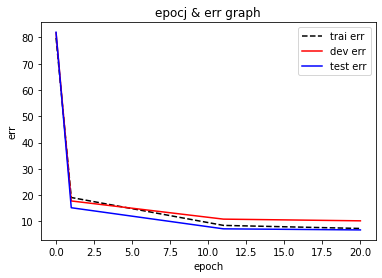

In [19]:
if(to_train):
  plt.plot(x_epoch,y_train_err, color='black',label='trai err', linestyle='--')
  plt.plot(x_epoch, y_dev_err, color='red',label='dev err')
  plt.plot(x_epoch, y_test_err, color='blue',label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epocj & err graph')
  plt.legend(loc='upper right')
  plt.show()

Normalized confusion matrix


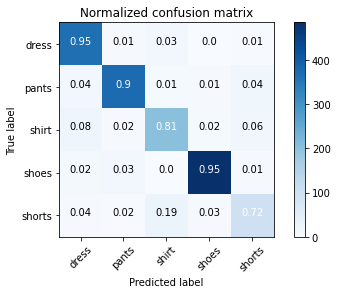

Confusion matrix, without normalization


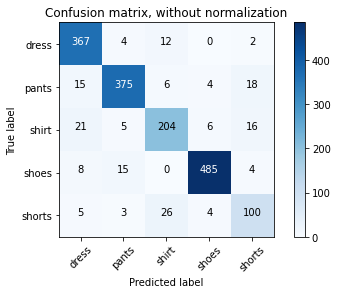

	 acc  |	 pre  |	 rec  |	 f1
 dress: 0.96 |	 0.88 |	 0.95 |	 0.92
 pants: 0.93 |	 0.93 |	 0.90 |	 0.91
 shirt: 0.91 |	 0.82 |	 0.81 |	 0.82
 shoes: 0.93 |	 0.97 |	 0.95 |	 0.96
 shorts: 0.95 |	 0.71 |	 0.72 |	 0.72
*accuracy: 0.94, precision: 0.86, recall: 0.87, *f1 score: 0.87
[AP]
dress: 0.97
pants: 0.97
shirt: 0.91
shoes: 0.99
shorts: 0.82

[mAP] 0.934
[miAP] 0.971


(array([0, 0, 0, ..., 2, 4, 4]),
 array([0, 0, 0, ..., 4, 4, 4]),
 array([0.95489913, 0.9159115 , 0.99975437, ..., 0.56205755, 0.55583644,
        0.82322645]))

In [20]:
model.eval()
utils.EvaluateClassifier(dev_batch,model,dev_data.classes,batch_size)

/content/drive/MyDrive/Colab Notebooks/utils.py:44: RuntimeWarning: overflow encountered in exp
  sum = sum + np.exp(arr[i])
/content/drive/MyDrive/Colab Notebooks/utils.py:47: RuntimeWarning: overflow encountered in exp
  arr[i] = np.exp(arr[i]) / sum
/content/drive/MyDrive/Colab Notebooks/utils.py:47: RuntimeWarning: invalid value encountered in true_divide
  arr[i] = np.exp(arr[i]) / sum


Normalized confusion matrix


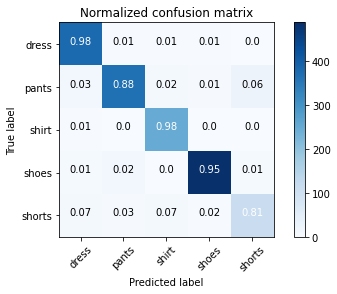

Confusion matrix, without normalization


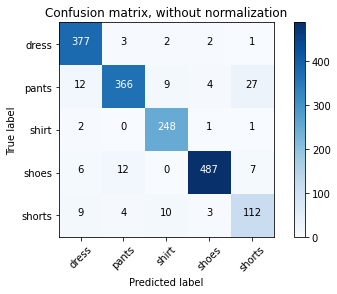

	 acc  |	 pre  |	 rec  |	 f1
 dress: 0.98 |	 0.93 |	 0.98 |	 0.95
 pants: 0.95 |	 0.95 |	 0.88 |	 0.91
 shirt: 0.95 |	 0.92 |	 0.98 |	 0.95
 shoes: 0.95 |	 0.98 |	 0.95 |	 0.97
 shorts: 0.96 |	 0.76 |	 0.81 |	 0.78
*accuracy: 0.96, precision: 0.91, recall: 0.92, *f1 score: 0.91
[AP]
dress: 0.99
pants: 0.98
shirt: 1.00
shoes: 0.85
shorts: 0.86

[mAP] 0.934
[miAP] 0.978


In [21]:
model.eval()
_,_,_ = utils.EvaluateClassifier(test_batch,model,test_data.classes,batch_size)

Category: dress
 True predicted images/total dress category: 367 / 385
Predicted probability:
[0.95489913 0.02835441 0.00794107 0.0050185  0.00378689]


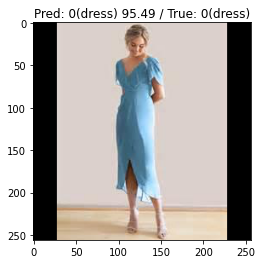

 False predicted images/total dress category: 18 / 385
Predicted probability:
[0.09997138 0.81329435 0.02816599 0.04407123 0.01449705]


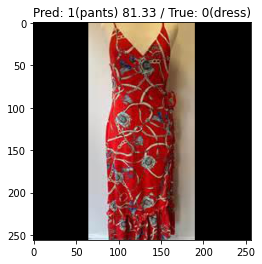

Category: pants
 True predicted images/total pants category: 375 / 418
Predicted probability:
[8.2914333e-09 9.9999875e-01 2.4527685e-07 7.1970794e-07 2.7316915e-07]


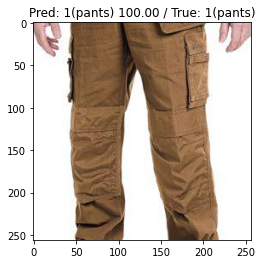

 False predicted images/total pants category: 43 / 418
Predicted probability:
[0.10129656 0.3458623  0.12936723 0.0702318  0.3532421 ]


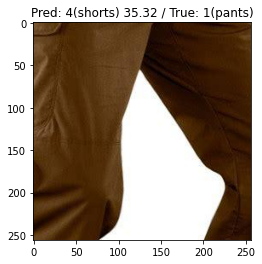

Category: shirt
 True predicted images/total shirt category: 204 / 252
Predicted probability:
[0.19402473 0.0533084  0.51479894 0.00544018 0.23242773]


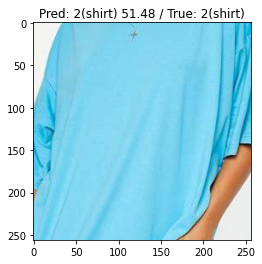

 False predicted images/total shirt category: 48 / 252
Predicted probability:
[0.01269999 0.06345374 0.01601088 0.8786469  0.02918851]


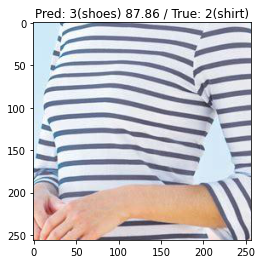

Category: shoes
 True predicted images/total shoes category: 485 / 512
Predicted probability:
[1.0588133e-06 7.2942798e-06 1.2647049e-08 9.9999100e-01 6.5568497e-07]


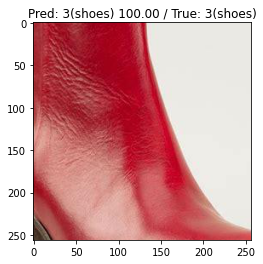

 False predicted images/total shoes category: 27 / 512
Predicted probability:
[7.2102353e-07 9.9986774e-01 8.7704893e-07 1.2701079e-04 3.6265017e-06]


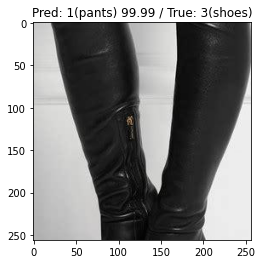

Category: shorts
 True predicted images/total shorts category: 100 / 138
Predicted probability:
[0.09275443 0.04974446 0.3253952  0.00634622 0.5257597 ]


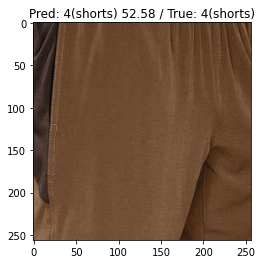

 False predicted images/total shorts category: 38 / 138
Predicted probability:
[7.9175056e-04 3.4964709e-03 8.0110830e-01 1.1248563e-03 1.9347863e-01]


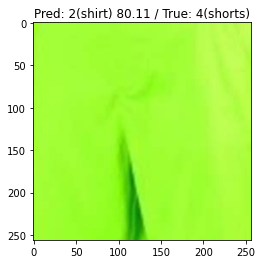

In [24]:
utils.VisTFPred(dev_batch, model, test_data.classes,batch_size, i_n=1)